# Beispiel 8.4: Zeitlicher Reaktionsablauf bei exothermer reversibler Reaktion
Bearbeitet von Amke Wiesner

Dieses Beispiel befindet sich im Lehrbuch auf der Seite 101. Die Nummerierung der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch.

# Code
Laden der benötigten Pakete. Das Paket *scipy* wird in diesem Beispiel zum Lösen der gekoppelten Differentialgleichungen eingesetzt.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Im nächsten Schritt werden die aus dem Beispiel bekannten Daten in Variablen angelegt. Sie sind im Lehrbuch in der Bildunterschrift zu Abbildung 8.12 zu finden, dabei kennzeichnet *forward* die Hinreaktion und *backward* die Rückreaktion.

In [2]:
k0_forward  = 5e9            # 1/min       präexpoentieller Faktor Hinreaktion
k0_forward  = k0_forward/60  # 1/s         präexpoentieller Faktor Hinreaktion
Ea_forward  = 60e3           # J/mol       Aktivierungenergie Hinreaktion

k0_backward = 1e14           # 1/min       präexpoentieller Faktor Rückreaktion
k0_backward = k0_backward/60 # 1/s         präexpoentieller Faktor Rückreaktion
Ea_backward = 100e3          # J/mol       Aktivierungsenergie Rückreaktion

Delta_R_H   = -40e3          # J/mol       Reaktionsenthalpie
Delta_T_ad  = 400            # K           adiabatische Temperaturdifferenz
T_0         = 400            # K           Eintrittstemperatur
T_K         = T_0            # K           mittlere Temperatur des Kühlmittels
tr          = 1.0            # s           Reaktionszeit (Annahme)
R           = 8.314          # J/(mol K)   universelle Gaskonstante

nu_1        = -1             # -           stöchiometrischer Faktor Komp. 1

Für verschiedenen Reaktionsführungen werden drei verschiedene Stanton-Zahlen *St* definiert.

In [3]:
St_isoth = 20e3   # isotherme Reaktionsführung: St gegen + unendlich
St_ad    = 0      # adiabate Reaktionsführung:  St gegen 0
St_poly  = 20     # polytrope Reaktionsführung: St zwischen adiabat und isotherm      

Die Berechnung der drei Reaktionsführungen läuft analog zueinander ab. Es bietet sich daher an, das Problem mit einer Schleife zu lösen. Dazu wird ein Array erstellt, der alle Varianten der Stanton-Zahl enthält.

In [4]:
St = [St_ad, St_poly, St_isoth]

Im nächsten Schritt wird der Zeitbereich festgelegt, der in der Berechnung betrachtet wird.

In [5]:
t = np.linspace(0, 3, 1001) # dimensionslose Zeit

## Dimensionslose Kennzahlen

Da einige verwendete dimensionslosen Kennzahlen (Damköhler-Zahl, Arrhenius-Zahl, Prater-Zahl und dimensionslose Kühltemperatur) für diese Fragestellung konstant sind, können sie vor dem Lösen der Bilanzen berechnet werden.

In [6]:
Da_forward = k0_forward * np.exp(-Ea_forward / (R * T_0)) * tr      # Glg. (8.4f)
print('Damköhler, Hinreaktion: ', round(Da_forward,3))

gamma_forward = Ea_forward / (R * T_0)                              # Glg. (8.4i)
print('Arrhenius, Hinreaktion: ', round(gamma_forward,3))

print( )

Da_backward = k0_backward * np.exp(-Ea_backward / (R * T_0)) * tr   # Glg. (8.4f)
print('Damköhler, Rückreaktion: ', round(Da_backward,3))

gamma_backward = Ea_backward / (R * T_0)                            # Glg. (8.4i)
print('Arrhenius, Rückreaktion: ', round(gamma_backward,3))

print( )

beta = Delta_T_ad / T_0                   # Glg. (8.4g)                         
print('Prater: ', round(beta, 3))

Theta_K = T_K / T_0                       # Glg. (8.4e)
print('Theta_Kühl : ', round(Theta_K,3))

Damköhler, Hinreaktion:  1.217
Arrhenius, Hinreaktion:  18.042

Damköhler, Rückreaktion:  0.145
Arrhenius, Rückreaktion:  30.07

Prater:  1.0
Theta_Kühl :  1.0


## Lösen des Gleichungssystems

Die dimensionslose Materialbilanz wird auf Basis des in Glg. (8.5) aufgeführten Ausdrucks aufgestellt. Im Ausdruck der Reaktionsgeschwindigkeit wird die reversible Reaktion wie folgt berücksichtigt:
\begin{equation}
r = k_+ c_\text{1} - k_- c_\text{2}
\end{equation}

Zur Lösung der Gleichung werden die bereits berechneten dimensionslosen Kennzahlen verwendet.
Für die Komponente A$_\text{1}$ resultiert folgende Gleichung, die im Gleichungssystem verwendet wird:

\begin{equation*}
\frac{df_1}{d \theta} = -Da_+ \cdot exp \bigg( \gamma_+ \cdot \Big( \frac{\vartheta - 1}{\vartheta} \Big) \bigg) \cdot f_1 + Da_- \cdot exp \bigg( \gamma_- \cdot \Big( \frac{\vartheta - 1}{\vartheta} \Big) \bigg) \cdot \Big( 1 - f_1 \Big)
\end{equation*}

Ausgangspunkt für die Energiebilanz ist Glg. (8.6). Auch in dieser Bilanz wird die reversible Reaktion berücksichtigt und die nach Glg. (8.4) bestimmten dimensionslosen Kennzahlen zur Berechnung verwendet. Folgende Gleichung wird im Gleichungssystem verwendet:

\begin{equation*}
\frac{d \vartheta}{d \theta} = \beta \cdot \Bigg[ Da_+ \cdot exp \bigg( \gamma_+ \cdot \Big( \frac{\vartheta - 1}{\vartheta} \Big) \bigg) \cdot f_1 - Da_- \cdot exp \bigg( \gamma_- \cdot \Big( \frac{\vartheta - 1}{\vartheta} \Big) \bigg) \cdot \Big( 1 - f_1 \Big) \Bigg] - St \Big( \vartheta - \vartheta_\text{K} \Big)
\end{equation*}

### Ausführung
Um die Ergebnisse für jeden der drei betrachteten Fälle zu speichern, werden Speichervariablen für die Parameter Restanteil, dimensionslose Zeit und dimensionslose Temperatur angelegt, auf die später zugegriffen werden kann. Diese Variablen sind mit *save* gekennzeichnet und werden an dieser Stelle zunächst initialisiert.

In [7]:
f_save    = [0,0,0]  # Restanteil
time_save = [0,0,0]  # dimensionslose Zeit
temp_save = [0,0,0]  # dimensionslose Temperatur

In einer while-Schleife wird nun für jede Stanton-Zahl das Gleichungssystem aus Material- und Energiebilanzgleichung gelöst. Die Ergebnisse werden in den Speichervariablen gespeichert.

In [8]:
i = 0

while i < len(St):
    
    def batch (y, t):
        f, T = y
        
        # dimensionslose Materialbilanz
        dfdt = -Da_forward * np.exp(gamma_forward * ((T - 1)/(T))) * f + Da_backward * np.exp(gamma_backward * ((T - 1)/(T))) * (1-f)
        # dimensionslose Energiebilanz
        dTdt = beta * (+ Da_forward * np.exp(gamma_forward * ((T - 1)/(T))) * f - Da_backward * np.exp(gamma_backward * ((T - 1)/(T))) * (1-f)) - St[i] * (T - Theta_K)
        
        return dfdt, dTdt
    
    # Anfangsbedingungen
    f0, T0 = 1.0, 1.0
    y0 = f0, T0
    
    # Lösen
    solve = odeint(batch, y0, t)  # Anmerkung zum Solver im folgenden Textblock
    f,T = solve.T
    
    # Speichern
    f_save[i]    = f
    time_save[i] = t
    temp_save[i] = T
    
    i = i+1

__Odeint-Solver__

Dieser Solver aus dem Paket *scipy* wird eingsetzt, um Differentiagleichungen (DGL) oder DGL-Systeme zu Lösen.
Die benötigten Argumente beinhalten:

\begin{equation*}
\text{odeint} \bigg( \text{Name} \space \text{des} \space \text{Modells}, \space \text{Anfangsbedingungen}, \space \text{Zeitbereich} \bigg)
\end{equation*}

Weitere Informationen zum Solver sind unter folgendem Link zu finden: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

## Restanteil im Gleichgewicht

In den folgenden Schritten wird der Restanteil im Gleichgewicht $f_\text{1,eq}$ berechnet. Dazu wird zunächst der Umsatzgrad im Gleichgewicht $U_\text{eq}$ nach Glg. (8.39) berechnet. Diese Berechnung wird für einen dimensionsbehafteten Temperaturbereich durchgeführt.

In [9]:
T = np.linspace(350,600,251)   # K      Temperatur

Mithilfe der Glg. (8.39) wird der Restanteil im Gleichgewicht berechnet.

In [10]:
k_forward  = k0_forward  * np.exp(-Ea_forward /(R * T))   # Glg. (5.7)
k_backward = k0_backward * np.exp(-Ea_backward/(R * T))   # Glg. (5.7)

K = k_forward / k_backward   # Glg. (8.39)

U_eq = K / (1+K)             # Glg. (8.39)
f_eq = 1 - U_eq              # Glg. (8.4b)

## Grafische Darstellung

Der Restanteil wird über der Temperatur und der Zeit dargestellt. Um die Grafiken nebeneinander darstellen zu können, wird der Befehl *subplots* verwendet. So können mehrere Grafiken beliebig zueinander angeordnet werden.

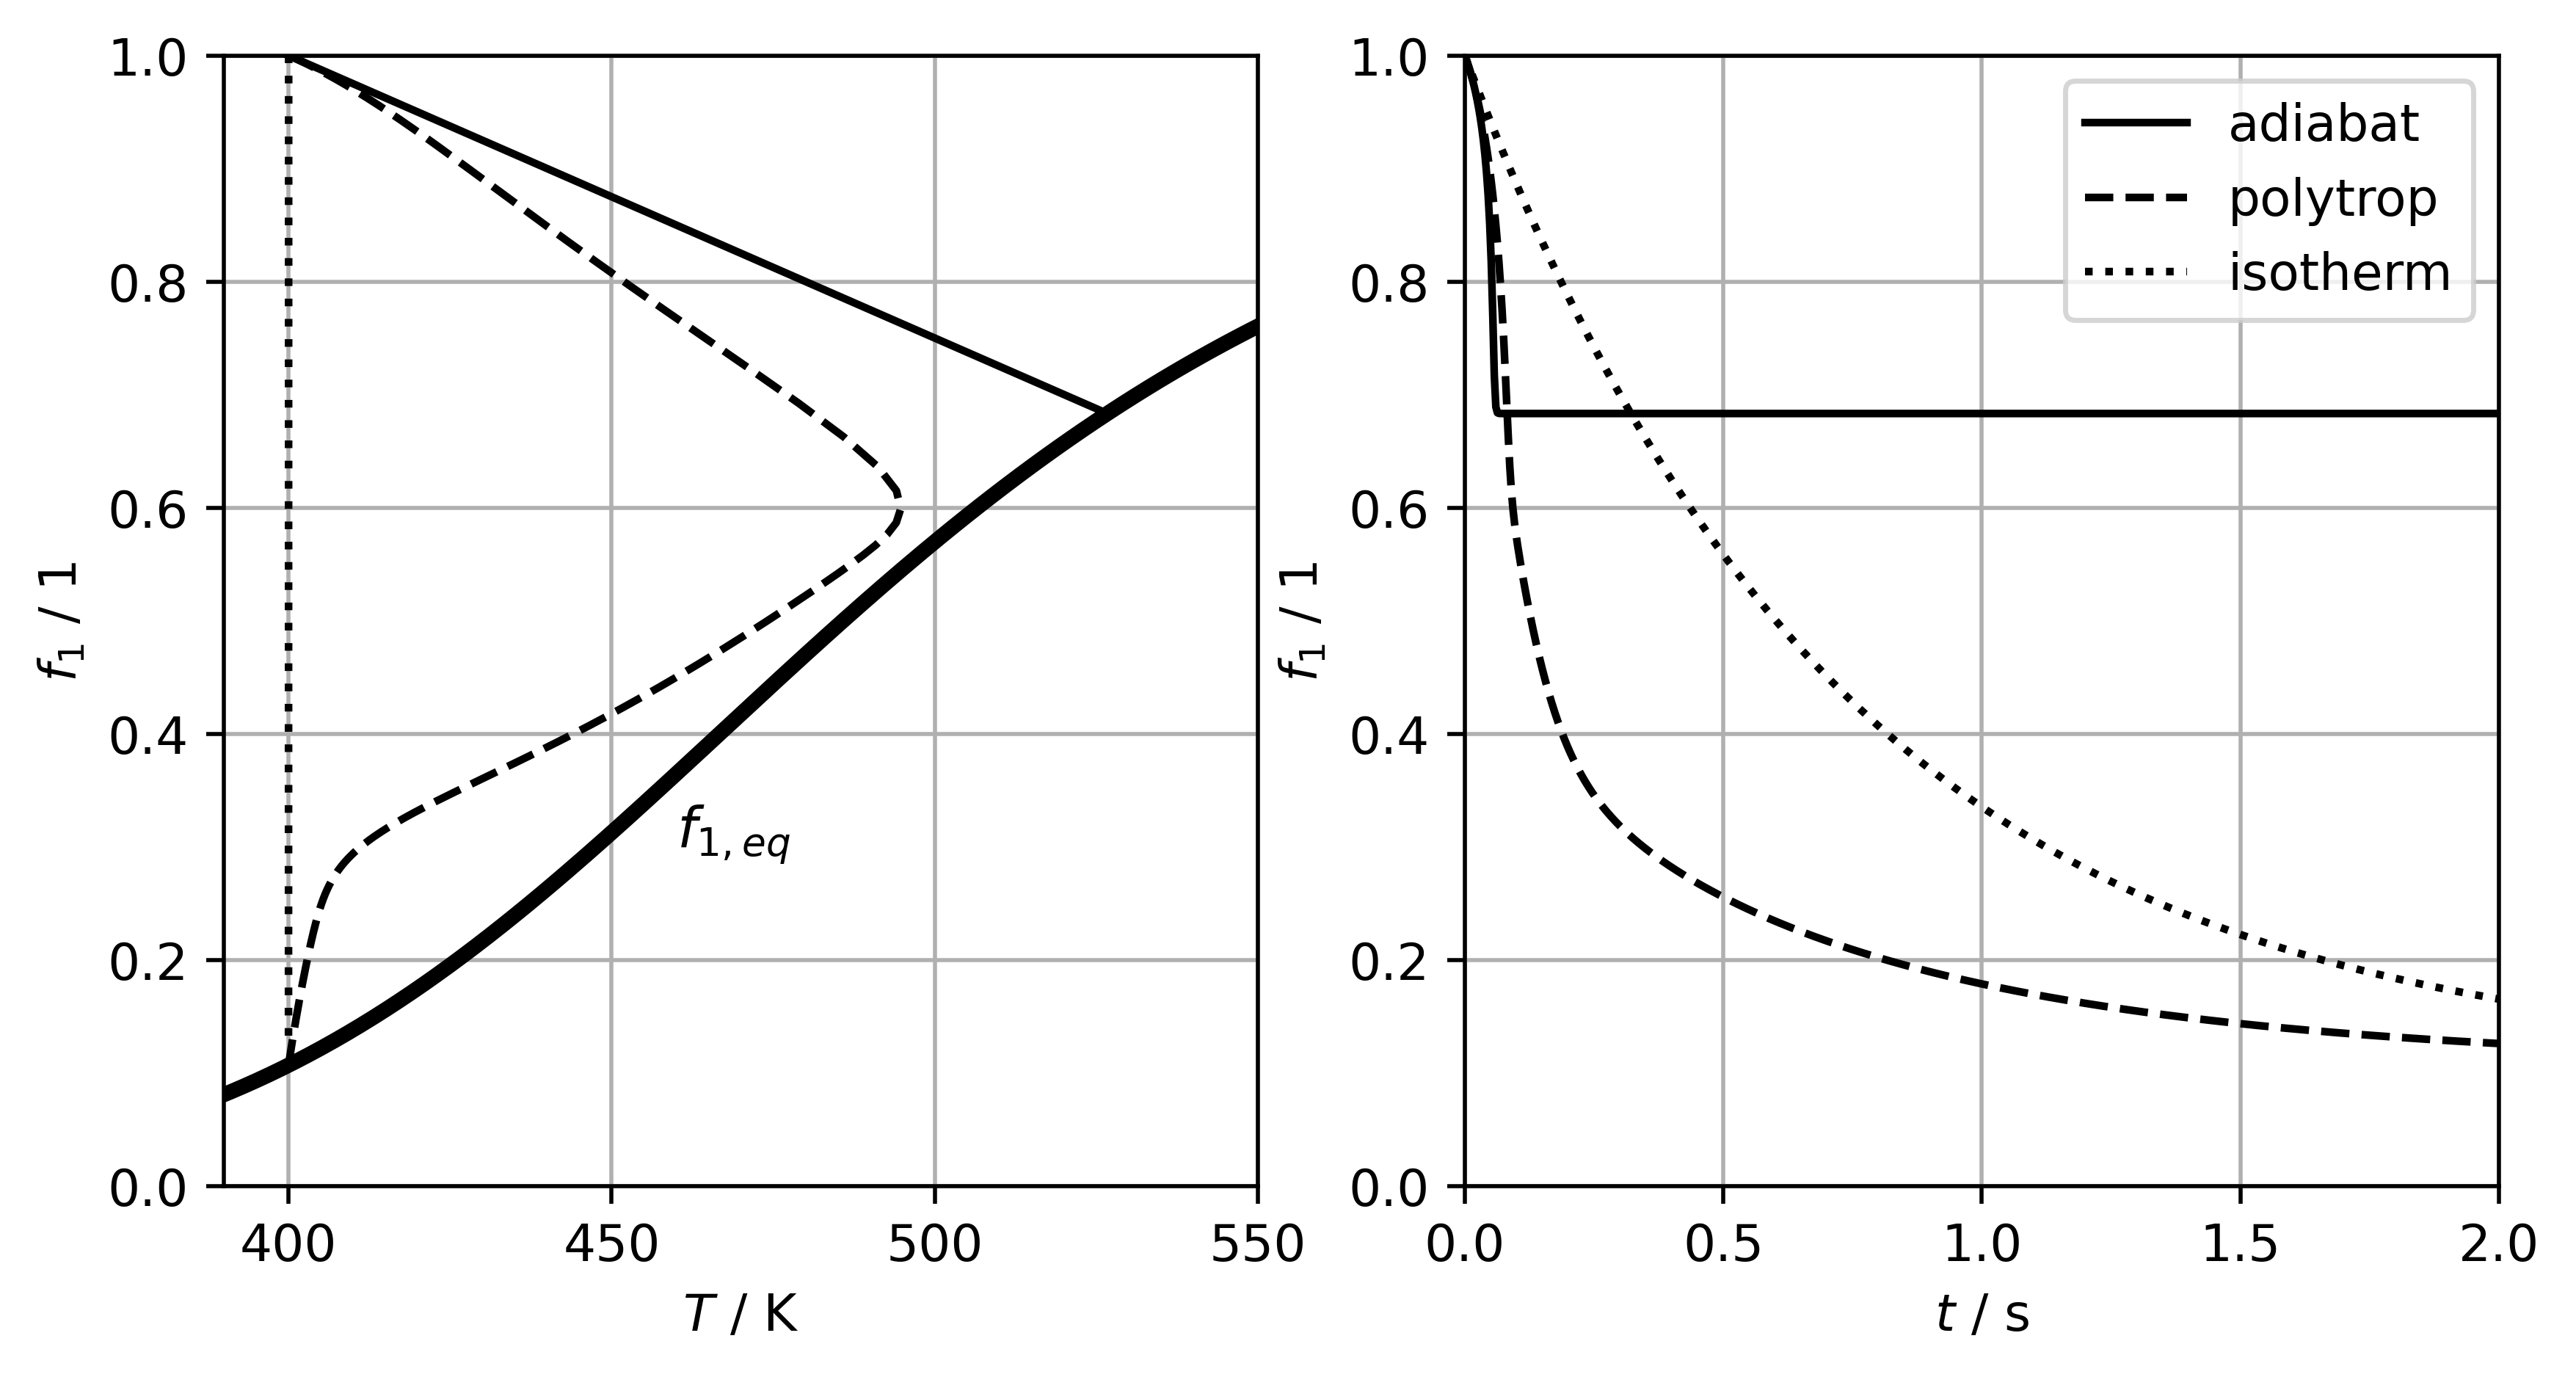

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), dpi = 500)

ax1.plot(temp_save[0] * T_0, f_save[0], label = 'adiabat',  linestyle = 'solid',  color = 'black')
ax1.plot(temp_save[1] * T_0, f_save[1], label = 'polytrop', linestyle = 'dashed', color = 'black')
ax1.plot(temp_save[2] * T_0, f_save[2], label = 'isotherm', linestyle = 'dotted', color = 'black')

ax1.plot(T, f_eq, linestyle = 'solid', color = 'black', linewidth = 3)
ax1.annotate(xy=(460,0.3), text = '$f_{1,eq}$', size = 11)

ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$f_1$ / 1')
ax1.set_xlim(390, 550)
ax1.set_ylim (0,1)

ax1.grid(True)


ax2.plot(time_save[0], f_save[0], label = 'adiabat',  linestyle = 'solid',  color = 'black')
ax2.plot(time_save[1], f_save[1], label = 'polytrop', linestyle = 'dashed', color = 'black')
ax2.plot(time_save[2], f_save[2], label = 'isotherm', linestyle = 'dotted', color = 'black')

ax2.set_xlabel('$t$ / s')
ax2.set_ylabel('$f_1$ / 1')
ax2.set_xlim (0,2)
ax2.set_ylim(0,1)

ax2.grid(True)
ax2.legend(loc = 'upper right')
plt.show()